In [1]:
# Packages
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Retrieve data

transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = (0,1,2,3,4,5,6,7,8,9)

In [3]:
# plot packages
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# function to display digit batch
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

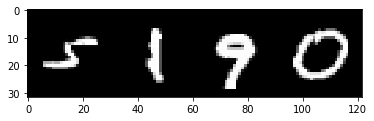

ground truth:     5     1     9     0


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("ground truth:", ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# My LeNet5 Model
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=5, padding=2)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=5)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=5)),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, image):
        output = self.convnet(image)
        output = output.view(image.size(0), -1)
        output = self.fc(output)
        return output
            
net = LeNet5()
print(net)

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=84, out_features=10, bias=True)
    (sig7): LogSoftmax()
  )
)


In [7]:
# define loss function and optimizer
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [8]:
# Train the network

for epoch in range(2): # loop over dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finish Training")

[1,  2000] loss: 0.418
[1,  4000] loss: 0.155
[1,  6000] loss: 0.116
[1,  8000] loss: 0.105
[1, 10000] loss: 0.087
[1, 12000] loss: 0.088
[1, 14000] loss: 0.078
[2,  2000] loss: 0.063
[2,  4000] loss: 0.061
[2,  6000] loss: 0.056
[2,  8000] loss: 0.061
[2, 10000] loss: 0.065
[2, 12000] loss: 0.061
[2, 14000] loss: 0.062
Finish Training


In [9]:
# Save our model
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

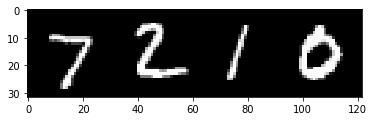

GroundTruth:      7     2     1     0


In [10]:
# Test the network on the test data

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
# Load the parameters from scratch
net = LeNet5()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
# the predicted output
_, predicted = torch.max(net(images), 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:      7     2     1     0


In [13]:
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98.290000 %


In [14]:
# What are the classes that performed well, and the classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 99 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 96 %
Accuracy of     9 : 98 %
